# Exercise 6: Clustering

In this assignment you will experiment with k-means as an image compression algorithm.

## Read the following instructions carefully:

1. Unlike previous notebooks, most of this exercise will be graded automatically. Your will write **all** of your core functions in a script named `src/hw6.py` and it will be tested automatically. This jupyter notebook contains the instructions for the exercise, visualizations and qualitative questions that should be answered in the notebook itself. Note that you are allowed to use the notebook for any tests you want to run.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in `src/hw6.py` only. **Do not create additional Python modules**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook and the `src/hw6.py` file only. Use **ZIP** and name the file using your ID. For example: `hw6_123456789_987654321.zip` if you submitted in pairs and `hw6_123456789.zip` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support) within this notebook. **Answers that will be written in commented code blocks will not be checked.**

## Color image quantization

Color image quantization is the process of transforming an image so that it can be represented with a small subset of colors; a subset smaller than the image's original palette size. Image quantization is a form of lossy data compression since the number of bits used for the palette is reduced. During this compression some data is lost and therefore we must use a careful algorithm that will minimize the perceived difference between the original image and its quantized counterpart. Other than compression, image quantization plays an important role in image recognition algorithms.

When representing images in true color, each pixel is represented by 3 RGB components and each one of the 3 RGB components is represented by 8 bits and can take a value from 0 to 255. This means that in true color representation one can use 2^24≈16 Million different colors. In this exercise we will perform image quantization from images given in true color into 256, 16 or even less colors.

There are many algorithms for quantization. In this exercise, you are going to use K-means in color space to achieve quantization. The color (a point in RGB space) assigned to each pixel is the color of the centroid of the cluster. 

To summarize, every pixel in the image is a point in the three dimensional RGB space. We want to cluster these points into k clusters and then replace each pixel by the centroid of the cluster to which it was assigned to obtain the compressed image.

You might need to install skimage using `conda install -c conda-forge scikit-image`.

Also, note that `numpy.power()` is a slow function! https://stackoverflow.com/questions/25254541/why-is-numpy-power-60x-slower-than-in-lining

In [1]:
# this will reload the python modules automatically
# so changes you make in the hw6.py script will be updated
# automatically within this notebook
%load_ext autoreload
%autoreload 2

import numpy as np
from skimage import io
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

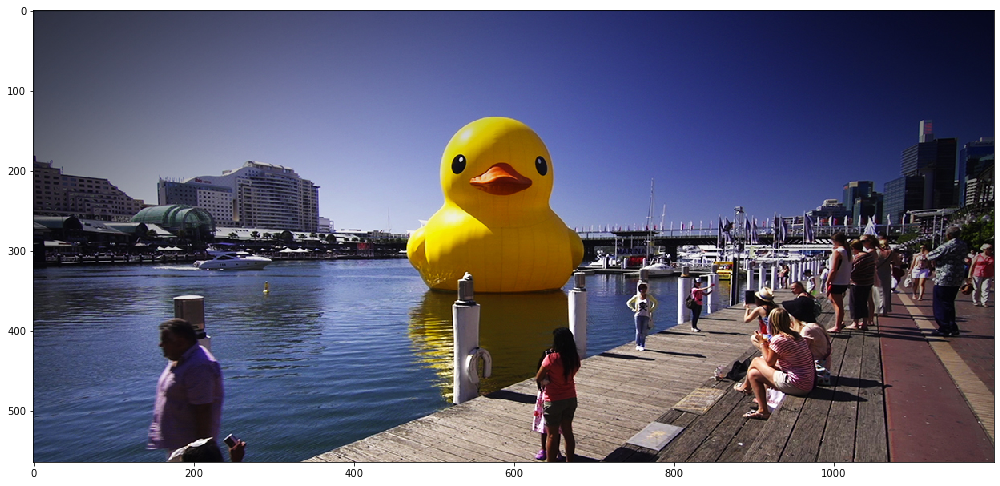

(564, 1200, 3)


In [2]:
# load the image and confirm skimage is imported properly.
image = io.imread('hw6_data/small_duck.jpg')
io.imshow(image)
io.show()
print(image.shape)

This single image has over 2 million values. Make sure your code is vectorized and efficient!

In [3]:
# save the dimensions of the image and reshape it for easier manipulation
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(image.shape[0]*image.shape[1],3)
print(image.shape)

(676800, 3)


## Random centroids (15 points)

Each centroid is a point in RGB space (color) in the image. This function should uniformly pick `k` centroids from the dataset.

Open the file `src/hw6.py` and complete the function `get_random_centroids`.

This function should take as input a single image of shape `(num_pixels, 3)` and `k`, the number of centroids. Notice we are flattening the image to a two dimensional array for easier manipulation. This function should return randomly chosen centroids of shape `(k,3)` as a numpy array. Make sure you are choosing different values.

In [123]:
from src.hw6 import get_random_centroids

k = 7 
centroids = get_random_centroids(image, k)

In [124]:
np.random.seed(42)
print(f"centroids array:\n\n{centroids}\n\ncentroid array dim:{centroids.shape}")

centroids array:

[[ 55.  65. 137.]
 [175. 163. 147.]
 [ 17.  22.  60.]
 [156.  97.  91.]
 [ 33.  27.  29.]
 [ 90.  77.  69.]
 [ 16.  23.  65.]]

centroid array dim:(7, 3)


## Distance function (25 points)

The Minkowski distance is a metric which can be considered as a generalization of the Euclidean and Manhattan distances. 

The Minkoski distance of order $p$ between two points: $\vec{x}=(x_1, ..., x_n)$ and $\vec{y}=(y_1, ..., y_n)$ is:
$$D(\vec{x},\vec{y}) = (\sum_{i=1}^n \mid x_i - y_i \mid ^p)^{\frac{1}{p}}$$

Open the file `src/hw6.py` and complete the function `lp_distance`.

Inputs: 
* a single image of shape `(num_pixels, 3)`.
* the centroids `(k, 3)`.
* the distance parameter p.

Output: numpy array of shape `(k, num_pixels)` thats holds the distances of all points in RGB space from all centroids.

In [127]:
from src.hw6 import lp_distance

In [128]:
# each row = distances from corresponding centroid (row number) to EVERY point in the image
distances = lp_distance(image, centroids, 2)

In [129]:
distances.mean(axis=0)

array([79.13092032, 80.66736866, 79.40504583, ..., 83.94014401,
       83.28914998, 82.76129036])

In [130]:
# sanity check
assert distances.shape == (centroids.shape[0], image.shape[0])
print(f'distances dim: {distances.shape}, centroids rows: {centroids.shape[0]}, image rows: {image.shape[0]}')

distances dim: (7, 676800), centroids rows: 7, image rows: 676800


In [131]:
print(f'distances array 1st row:\n\n{distances[0]}\n\ndistances array dim: {distances.shape}')

distances array 1st row:

[52.47856705 75.27283707 64.66065264 ... 88.55506761 87.04022059
 85.25256594]

distances array dim: (7, 676800)


## Kmeans algorithm (40 points)

Calculate the locally optimal centroids as learned in class. At each iteration, assign every RGB point to its closest centroid and calculate new centroids by averaging the points that were assigned to every centroid. This function stops, when no improvement was made or once max_iter iterations is reached.

A reasonable implementation runs on a Core i7 CPU in less than a minute with `k=16`.

Open the file `src/hw6.py` and complete the function `kmeans`.

Inputs:
- X: a single image of shape (num_pixels, 3).
- k: number of centroids.
- p: the parameter governing the distance measure.
- max_iter: the maximum number of iterations to perform. (default value = 100).

Outputs:
- The calculated centroids as a numpy array.
- The final assignment of all RGB points to the closest centroids as a numpy array.
"""


In [87]:
from src.hw6 import kmeans

In [88]:
%%time
centroids, classes = kmeans(image, k=8, p=2, max_iter=100)

CPU times: user 15.5 s, sys: 1.31 s, total: 16.8 s
Wall time: 16.8 s


In [53]:
print('CPU time for k=16: 39.5s - user 35.4s, sys 4.0s')

CPU time for k=16: 39.5s - user 35.4s, sys 4.0s


We obtained the locally optimal centroids (colors) from our image. To reconstruct the compressed image, we need to specify the color for each pixel that our algorithm associated with a centroid. The following cell does that for you.

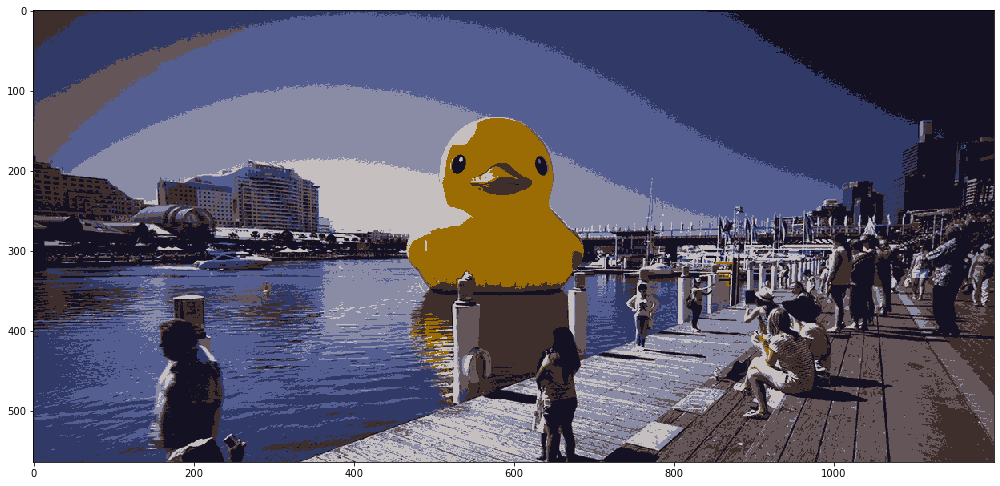

In [89]:
classes = classes.reshape(rows,cols) 
compressed_image = np.zeros((classes.shape[0], classes.shape[1],3), dtype=np.uint8)
for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
            compressed_image[i,j,:] = centroids[classes[i,j],:]
io.imshow(compressed_image)
io.show()

## Kmeans++ (20 points)


Open the file `src/hw6.py` and complete the function `kmeans_pp`. 

kmeans++ is an algorithm for choosing the initial centroids for the k-means clustering algorithm.

The idea is as follows:

1. Choose a centroid uniformly at random among the data points.
2. For each data points not chosen yet, compute the distance between the data point and the single nearest centroid that had already been chosen.
3. Choose one new data point at random as a new centroid, using a weighted probability distribution where a data point is chosen with probability proportional to the square of the distance you calculated previously. For each data point, the weight will be equal to the square distance to the closest center divided by the total squared distance (to make sure the probability adds up to 1).
4. Repeat Steps 2 and 3 until k centroids have been chosen.
5. Now that the initial centroids have been chosen, proceed using standard k-means clustering.

Inputs:
- X: a single image of shape (num_pixels, 3).
- k: number of centroids.
- p: the parameter governing the distance measure.
- max_iter: the maximum number of iterations to perform. (default value = 100).

Outputs:
- The calculated centroids as a numpy array.
- The final assignment of all RGB points to the closest centroids as a numpy array.
"""

Run each algorithm (kmeans, kmeans++) 10 times and visualize the performance differences. Note, `kmeans_pp` should be implemented in the file `src/hw6.py`, but the visualization can either by implemented in the file `src/hw6.py` or in the notebook itself. Explain your results in a markdown cell.

In [115]:
from src.hw6 import kmeans_pp


In [116]:
%%time
centroids, classes = kmeans_pp(image, k=4, p=1, max_iter=100)

CPU times: user 3.74 s, sys: 298 ms, total: 4.04 s
Wall time: 4.04 s


Again, we can visualize the resulted image.

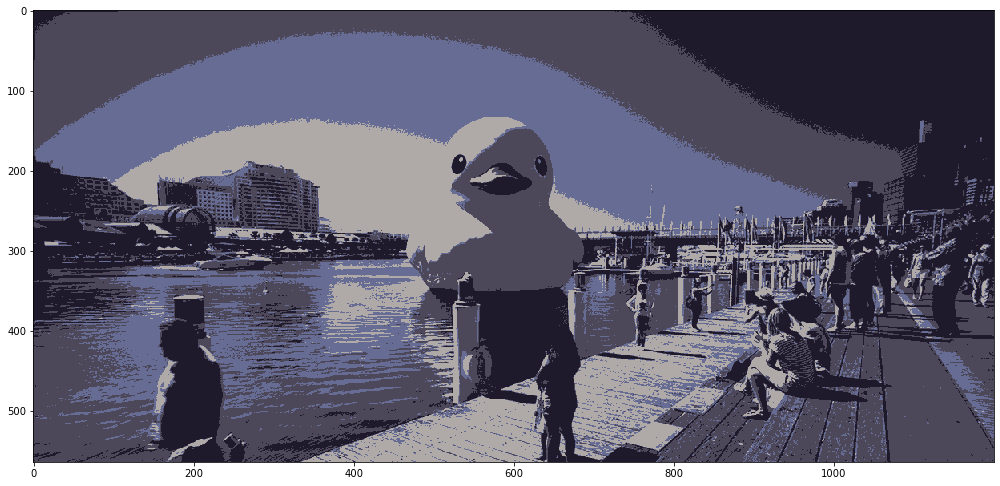

In [117]:
classes = classes.reshape(rows,cols) 
compressed_image = np.zeros((classes.shape[0], classes.shape[1],3), dtype=np.uint8)
for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
            compressed_image[i,j,:] = centroids[classes[i,j],:]
io.imshow(compressed_image)
io.show()

Don't forget to compare the results of kmeans with the improved kmeans++ and to explain your results in a markdown cell.

## WARNING: TAKES FOREVER TO RUN WITH P=2

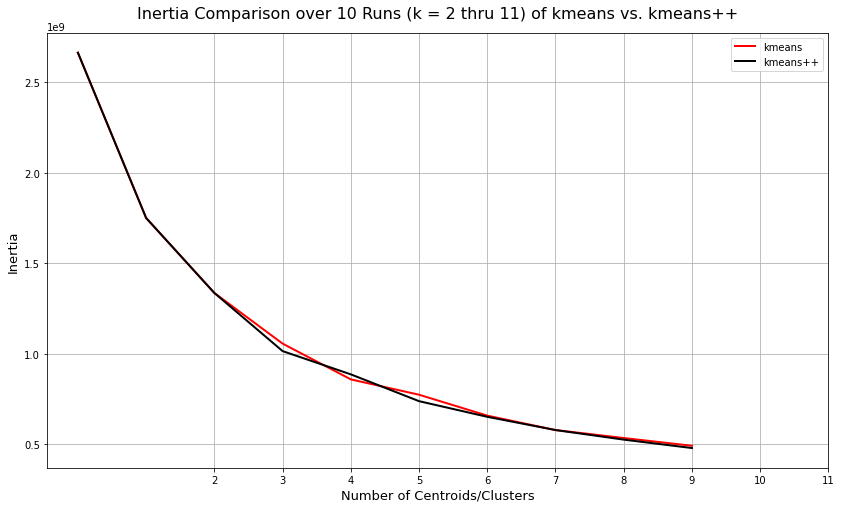

In [132]:
## Your code here ##
def calculate_inertia(X, centroids, p):
    return np.sum(np.square(lp_distance(X, centroids, p).min(axis=0)))

inertias, inertias_pp = [], []
for k in range(2,12):    
    centroids, classes = kmeans(image, k=k, p=2, max_iter=100)
    centroids_pp, classes_pp = kmeans_pp(image, k=k, p=2, max_iter=100)
    inertias.append(calculate_inertia(image, centroids, p=2))
    inertias_pp.append(calculate_inertia(image, centroids_pp, p=2))

plt.title(f'Inertia Comparison over 10 Runs (k = 2 thru 11) of kmeans vs. kmeans++', fontsize=16, y=1.02)
plt.plot(np.arange(2,12), inertias, label='kmeans', color='r', linewidth=2)
plt.plot(np.arange(2,12), inertias_pp, label='kmeans++', color='k', linewidth=2)

plt.xlabel('Number of Centroids/Clusters', fontsize=13)
plt.ylabel('Inertia', fontsize=13)
plt.xticks(np.arange(2,12))
plt.grid()
plt.legend()
plt.show();


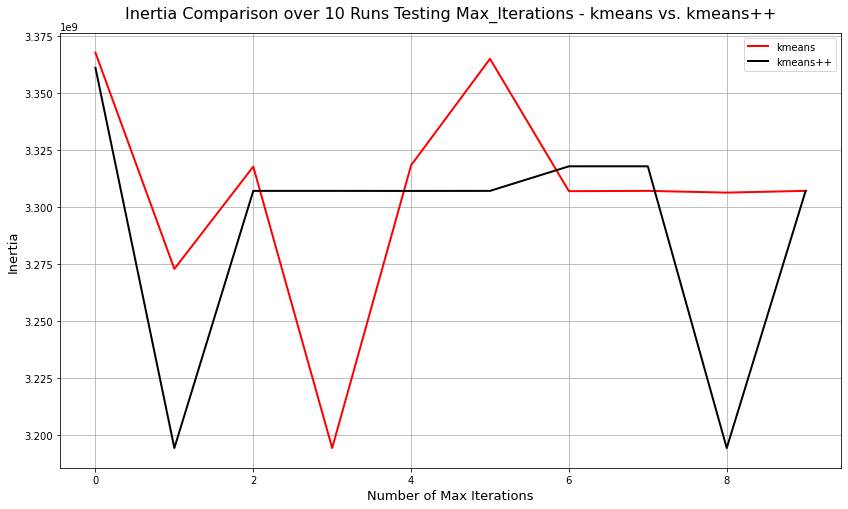

In [145]:
inertias, inertias_pp = [], []
iterations = [10,25,50,100,200,300,400,500,750,1000]
for iters in iterations:    
    centroids, classes = kmeans(image, k=4, p=1, max_iter=iters)
    centroids_pp, classes_pp = kmeans_pp(image, k=4, p=1, max_iter=iters)
    inertias.append(calculate_inertia(image, centroids, p=1))
    inertias_pp.append(calculate_inertia(image, centroids_pp, p=1))

plt.title(f'Inertia Comparison over 10 Runs Testing Max_Iterations - kmeans vs. kmeans++', fontsize=16, y=1.02)
plt.plot(inertias, label='kmeans', color='r', linewidth=2)
plt.plot(inertias_pp, label='kmeans++', color='k', linewidth=2)

plt.xlabel('Number of Max Iterations', fontsize=13)
plt.ylabel('Inertia', fontsize=13)
plt.grid()
plt.legend()
plt.show();

Your explanation here
## Explanation of Results Comparing K-Means to K-Means++ Clustering:

1. When comparing the 2 algorithms running 10 different values of k (or centroids/clusters), between 2-11, the differences between the two algorithms were tough to detect with kmeans (red line) initially performing worse with higher inertia, then a switch back to kmeans++ underperforming, then flipped again, and eventually appear to converge to nearly identical inertia. 

2. We then tried to run comparisons based on number of max iterations, as k-means++ is posited to be an "improved" algorithm in terms of requiring fewer iterations to reach better inertia scores. This resulted in wild gyrations in the performances of the algorithms, so it's hard to conclude very much. 

